# Main notebook: computing correlations between offensiveness and popularity
In this notebook we are trying to answer our previous questions: is there a correlation between (positive or negative) between the popularity and the offensiveness of a song ? Let's start by importing our libraries:

In [220]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

Remember, we have computed the song word count at three levels of "swear word categories":

In [160]:
offensiveness_rating = pd.read_pickle("../pickles/offensiveness_rating_structured")
offensiveness_rating.head()

('TRAAAAV128F421A322', 'non-discriminatory', 'mild', nan)      1
('TRAAAAV128F421A322', nan, nan, nan)                        102
('TRAAABD128F429CF47', nan, nan, nan)                        226
('TRAAAED128E0783FAB', nan, nan, nan)                        421
('TRAAAEF128F4273421', nan, nan, nan)                        139
Name: count, dtype: int64

Now, the problem is that we have tuples as index but we would like to have all these categories in different columns. So we do some processing to take care of that:

In [48]:
def process_tuple(t):
    
    def process_tuple_elem(elem):
        if elem == "nan":
            return np.nan
        else:
            return elem[1:-1]
    return list(map(process_tuple_elem, t[1:-1].replace(" ", "").split(",")))
index_offensiveness = list(map(process_tuple, offensiveness_rating.index.tolist()))

In [54]:
value_offensiveness = list(offensiveness_rating.values)

In [62]:
data_non_flat = list(zip(index_offensiveness, value_offensiveness))

In [70]:
columns = ["track_id", "category", "strength", "target", "value"]
track_off = pd.DataFrame.from_records([elem[0] + [elem[1]] for elem in data_non_flat], columns=columns)
track_off = track_off.set_index(["track_id", "category", "strength", "target"])
track_off.head()

value
track_id           category           strength target       
TRAAAAV128F421A322 non-discriminatory mild     NaN         1
                   NaN                NaN      NaN       102
TRAAABD128F429CF47 NaN                NaN      NaN       226
TRAAAED128E0783FAB NaN                NaN      NaN       421
TRAAAEF128F4273421 NaN                NaN      NaN       139

That's it, we have our multi-index structure. Now, we have the choice: absolute or relative count of swear words in a song ? This choice is rather difficult. But, in some way, even if a song is longer than another one, we can (for now) consider that simply having more swear words is equivalent to being more vulgar. So let's simply count the number of swear words per song:

In [105]:
%%time 
track_offensiveness = track_off.groupby(by="track_id").apply(lambda frame: frame.reset_index().dropna(thresh = 3).value.sum())
track_offensiveness = track_offensiveness.fillna(0)

CPU times: user 11min 23s, sys: 236 ms, total: 11min 23s
Wall time: 11min 23s


And here is our frame relating a song with its offensiveness (so, for example, the song with track ID 'TRAAAAV128F421A322' contains one swear word)

In [161]:
track_offensiveness.head()

track_id
TRAAAAV128F421A322    1.0
TRAAABD128F429CF47    0.0
TRAAAED128E0783FAB    0.0
TRAAAEF128F4273421    0.0
TRAAAEW128F42930C0    0.0
dtype: float64

Let's save this:

In [110]:
track_offensiveness.to_csv("../datasets/track_offensiveness.csv")

We take only the columns we are interested in:

In [132]:
song_info = pd.read_csv("../datasets/song_info/total.csv")[["track_id", "genre", "song_hotness",
                                                            "song_id", "title", "year"]]

### English songs
We now want to do our analysis for english songs only so we read the corresponding track IDs. The process of "detecting" which songs are in english is described in [this notebook](handling_languages.ipynb).

In [176]:
english_songs = pd.read_csv("../datasets/tracks_english.csv", header=-1)[1]
print("We have {} english songs.".format(english_songs.shape[0]))
english_songs = english_songs.to_frame()
english_songs.columns = ["track_id"]
english_songs.head()

We have 202115 english songs.


,track_id
0,TRAAAAV128F421A322
1,TRAAABD128F429CF47
2,TRAAAED128E0783FAB
3,TRAAAEF128F4273421
4,TRAAAEW128F42930C0


In [179]:
english_track_offensiveness = english_songs.merge(track_offensiveness.reset_index(), on="track_id")
print("We have {} songs.".format(english_track_offensiveness.shape[0]))
english_track_offensiveness.columns = ["track_id", "abs_offensiveness"]
english_track_offensiveness.head()

We have 202115 songs.


,track_id,abs_offensiveness
0,TRAAAAV128F421A322,1.0
1,TRAAABD128F429CF47,0.0
2,TRAAAED128E0783FAB,0.0
3,TRAAAEF128F4273421,0.0
4,TRAAAEW128F42930C0,0.0


In [181]:
song_info_offensiveness = song_info.merge(english_track_offensiveness.reset_index(), on="track_id")
song_info_offensiveness = song_info_offensiveness.rename(columns={0: "abs_offensiveness"})
song_info_offensiveness.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness
0,TRBEEGF128F42AB67E,NaN,0.000000,SOMYKOX12A8C13D59F,Collision Course,0,9341,0.0
1,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1.0
2,TRBEEEA128F92E7EED,NaN,NaN,SOGLPMS12D02193D69,Fake Messiah (Album Version),2009,9339,0.0
3,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0.0
4,TRBEEXV128F93116C9,NaN,0.227736,SOJHHMQ12AB017C6A6,Don't Ya Ever Leave Me (Live),0,9348,0.0


That's good, we have more than 200000 english songs with absolute offensiveness value. The two other values we will be the most focused on are the song hotness and the year. So we need to keep those where the year is not 0 and the song hotness is not nan. For now, let's proceed by keeping only datapoints with positive hotness value.

### Keep positive hotness datapoints:

In [149]:
song_info_offensiveness_hotness = song_info_offensiveness[song_info_offensiveness.song_hotness > 0]

And now, let's compute the correlation for all songs independent of year:

In [150]:
song_info_offensiveness_hotness.song_hotness.corr(song_info_offensiveness_hotness["abs_offensiveness"])

0.0068508883434469994

So we do not really have a correlation which means something here. Let's try by keeping the hotness = 0 values (if we suppose that those songs were "complete flops"):

In [185]:
song_info_offensiveness.song_hotness.corr(song_info_offensiveness.abs_offensiveness)

-0.0049521674122630678

This does not tell us much neither...

So let's include the year and see what we get:

In [151]:
song_info_YOH = song_info_offensiveness_hotness[song_info_offensiveness_hotness.year > 0]
song_info_YOH.head()

,track_id,genre,song_hotness,song_id,title,year,abs_offensiveness
5,TRBEEZO12903D05259,NaN,0.520345,SOUDWTU12AC37746F7,Spade and Parade,1994,1.0
9,TRBEENZ12903CE81F8,NaN,0.386477,SOPAKAJ12AB0188E86,Why I Liked Bikini Kill,1995,0.0
11,TRBEELS128F42B63A8,NaN,0.557188,SOPPTXH12A8C1409BC,Sent By Angels,1992,0.0
13,TRBEEIV128F425DAA0,NaN,0.492714,SODLELQ12A8C137D00,To All A Good Night,2000,0.0
14,TRBEMOM128F933A303,NaN,0.637593,SOUCJJT12A58A79086,Life In The Rain,2001,0.0


And the correlation for songs where we have the year is:

In [152]:
song_info_YOH.song_hotness.corr(song_info_YOH.abs_offensiveness)

0.013040255204667648

Still not significant, but it increased (even if the increase is very small)

In [208]:
# group by:
year_correlation = song_info_YOH.groupby(by="year").apply(lambda frame: frame.song_hotness.corr(frame.abs_offensiveness))

# we drop the years where we have too few songs and we rename the columns
year_correlation = year_correlation.dropna()
year_correlation = year_correlation.to_frame().reset_index()
year_correlation.columns = ["year", "correlation"]

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


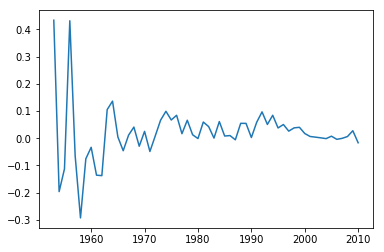

In [221]:
plt.plot(year_correlation.year.tolist(), year_correlation.correlation.tolist())